# Expression Quality Control (Part 2)

This is a template notebook for performing the final quality control on your organism's expression data. This requires a curated metadata sheet.

## Setup 

In [24]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os import path
from scipy import stats
from tqdm.notebook import tqdm

In [25]:
sns.set_style('ticks')

### Inputs

In [26]:
logTPM_file = path.join('../..','data','raw','log_tpm.csv') # Enter log-TPM filename here
all_metadata_file = path.join('../..','data','interim','metadata_qc_part1_all.tsv') # Enter full metadata filename here
metadata_file = path.join('../..','data','interim','metadata_qc_part1_curated.tsv') # Enter curated metadata filename here

### Load expression data

In [27]:
DF_log_tpm = pd.read_csv(logTPM_file,index_col=0).fillna(0)
print('Number of genes:',DF_log_tpm.shape[0])
print('Number of samples:',DF_log_tpm.shape[1])
DF_log_tpm.head()

Number of genes: 5886
Number of samples: 218


,135-Dmannitol,136-Dmannitol,138-Dcellobiose,140-Dcellobiose,145-Glycerol,146-Glycerol,149-LAlanine,150-LAlanine,155-Glucose,156-Glucose,...,ERX3196633,ERX3196634,ERX3196635,ERX3196636,ERX3196637,ERX3196638,ERX3196639,ERX3196640,ERX3196641,ERX3196642
Geneid,,,,,,,,,,,,,,,,,,,,,
XNR_RS30570,5.456942,5.932548,5.273563,5.247552,5.633562,5.144423,6.956123,6.619123,6.915530,7.009776,...,10.043968,7.418215,9.113020,8.377231,7.254333,6.487433,8.889477,6.106335,7.115429,6.756227
XNR_RS00005,6.031769,6.354998,5.707565,6.120847,0.000000,6.356647,7.970440,7.316582,8.335740,8.400185,...,5.647488,7.256560,5.341497,8.725397,6.950260,7.055077,5.202052,7.577470,6.292204,8.124065
XNR_RS00010,3.555950,3.055794,2.426080,2.287586,0.000000,0.000000,3.818268,4.241475,4.141733,4.401422,...,3.361203,0.000000,3.582991,2.412788,3.310946,3.693893,2.903043,2.888806,2.820050,3.606253
XNR_RS00015,7.052569,7.252028,7.252156,7.308897,7.412816,7.290919,7.402119,7.404085,7.604939,7.565636,...,7.723378,7.592051,8.554756,7.766569,8.645914,8.149561,6.950313,7.320063,8.669484,7.934139
XNR_RS00020,6.647861,6.692320,6.261563,6.332104,7.076383,6.990919,6.779826,6.447123,6.703674,6.999367,...,9.581257,9.507060,8.779298,7.860053,8.891415,9.349962,9.505341,9.699895,8.865316,9.685828


### Load metadata

In [28]:
DF_metadata = pd.read_csv(metadata_file,index_col=0, sep='\t')
print('Number of samples with curated metadata:',DF_metadata.shape[0])
DF_metadata.head()

Number of samples with curated metadata: 164


,sample_id,strain,benchling_strain_id,project,condition,notes,run,sequencing_run,LibraryLayout,Platform,R1,R2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation,skip,reference_condition
138-Dcellobiose,138-Dcellobiose,J1074,NaN,azenta,D-cellobiose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
140-Dcellobiose,140-Dcellobiose,J1074,NaN,azenta,D-cellobiose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
149-LAlanine,149-LAlanine,J1074,NaN,azenta,L-Alanine,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
150-LAlanine,150-LAlanine,J1074,NaN,azenta,L-Alanine,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
155-Glucose,155-Glucose,J1074,NaN,azenta,Glucose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control


In [29]:
DF_metadata_all = pd.read_csv(all_metadata_file,index_col=0, sep='\t')

## Remove samples due to poor metadata

After curation, some samples either did not have enough replicates or metadata to warrant inclusion in this database.

In [30]:
DF_metadata_passed_step4 = DF_metadata[~DF_metadata.skip.fillna(False)].copy()
print('New number of samples with curated metadata:',DF_metadata_passed_step4.shape[0])
DF_metadata_passed_step4.head()

New number of samples with curated metadata: 164


,sample_id,strain,benchling_strain_id,project,condition,notes,run,sequencing_run,LibraryLayout,Platform,R1,R2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation,skip,reference_condition
138-Dcellobiose,138-Dcellobiose,J1074,NaN,azenta,D-cellobiose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
140-Dcellobiose,140-Dcellobiose,J1074,NaN,azenta,D-cellobiose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
149-LAlanine,149-LAlanine,J1074,NaN,azenta,L-Alanine,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
150-LAlanine,150-LAlanine,J1074,NaN,azenta,L-Alanine,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control
155-Glucose,155-Glucose,J1074,NaN,azenta,Glucose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control


### Check curation
Since manual curation is error-prone, we want to make sure that all samples have labels for their project and condition. In addition, there should only be one reference condition in each project, and it should be in the project itself.

Any samples that fail these checks will be printed below.

In [31]:
assert(DF_metadata_passed_step4.project.notnull().all())
assert(DF_metadata_passed_step4.condition.notnull().all())

for name,group in DF_metadata_passed_step4.groupby('project'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    if not len(ref_cond) == 1:
        print('Multiple reference conditions for:, name')
    
    # Ensure the reference condition is in fact in the project
    ref_cond = ref_cond[0]
    if not ref_cond in group.condition.tolist():
        print('Reference condition not in project:', name)

Next, make a new column called ``full_name`` that gives every experimental condition a unique, human-readable identifier.

In [32]:
DF_metadata_passed_step4['full_name'] = DF_metadata_passed_step4['project'].str.cat(DF_metadata_passed_step4['condition'],sep=':')

### Remove samples with only one replicate

First, find sample names that have at least two replicates.

In [33]:
counts = DF_metadata_passed_step4.full_name.value_counts()
keep_samples = counts[counts >= 2].index
print(keep_samples[:5])

Index(['azenta:Monosodium glutamate', 'azenta:MSG 5% NaCl',
       'azenta:DnybW PkasOP::nybF::zwf2_70h', 'azenta:PkasOP::nybF::zwf2_46h',
       'azenta:72h MSG'],
      dtype='object')


Only keep these samples

In [34]:
DF_metadata_passed_step4 = DF_metadata_passed_step4[DF_metadata_passed_step4.full_name.isin(keep_samples)]
print('New number of samples with curated metadata:',DF_metadata_passed_step4.shape[0])
DF_metadata_passed_step4.head()

New number of samples with curated metadata: 150


,sample_id,strain,benchling_strain_id,project,condition,notes,run,sequencing_run,LibraryLayout,Platform,R1,R2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation,skip,reference_condition,full_name
138-Dcellobiose,138-Dcellobiose,J1074,NaN,azenta,D-cellobiose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control,azenta:D-cellobiose
140-Dcellobiose,140-Dcellobiose,J1074,NaN,azenta,D-cellobiose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control,azenta:D-cellobiose
149-LAlanine,149-LAlanine,J1074,NaN,azenta,L-Alanine,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control,azenta:L-Alanine
150-LAlanine,150-LAlanine,J1074,NaN,azenta,L-Alanine,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control,azenta:L-Alanine
155-Glucose,155-Glucose,J1074,NaN,azenta,Glucose,sample_id: (carbon source)-(biological replica...,NaN,run_03,PAIRED,ILLUMINA,/home/nilmat/reads/streptsd/ready/azenta_run_0...,/home/nilmat/reads/streptsd/ready/azenta_run_0...,True,True,True,False,control,azenta:Glucose


### Save this information to the full metadata dataframe

In [35]:
DF_metadata_all['passed_curation'] = DF_metadata_all.index.isin(DF_metadata_passed_step4.index)

## Check correlations between replicates

### Remove failed data from log_tpm files

In [36]:
DF_log_tpm = DF_log_tpm[DF_metadata_passed_step4.index]

### Compute Pearson R Score

There is precident for using 0.80 as Rcutoff value. This allows us to include all of the ERX samples in the study. Hoever, need to think carefully wether or not to include them, think about their replications (2 replicates but sampled a day apart). Additionally, plotting the samples on a PCA indicates that samples from 'K88E_mutation_in_rpsL_gene' and 'K88E_p91S_mutation_in_rpsL_gene_+del_rsmG' may have been mixed up.

In [37]:
rcutoff = 0.90

The following code computes correlations between all samples and collects correlations between replicates and non-replicates.

In [38]:
rep_corrs = {}
rand_corrs = {}

num_comparisons = len(DF_metadata_passed_step4)*(len(DF_metadata_passed_step4)-1)/2

for exp1,exp2 in tqdm(itertools.combinations(DF_metadata_passed_step4.index,2),total=num_comparisons):
    if DF_metadata_passed_step4.loc[exp1,'full_name'] == DF_metadata_passed_step4.loc[exp2,'full_name']:
        rep_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]
    else:
        rand_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]

  0%|          | 0/11175.0 [00:00<?, ?it/s]

Correlations can be plotted on a histogram

Median Pearson R between replicates: 0.99


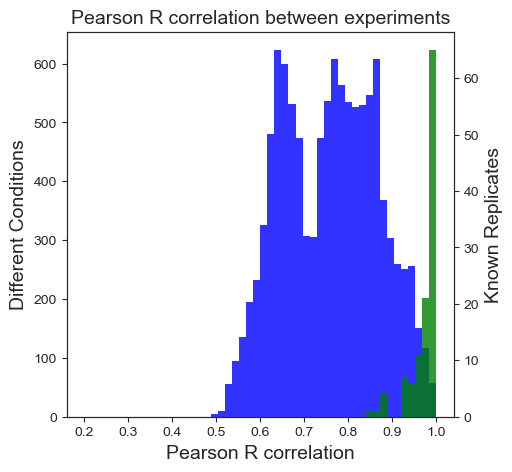

In [39]:
fig,ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax2.hist(rep_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='green',linewidth=0)
ax.hist(rand_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='blue',linewidth=0)
ax.set_title('Pearson R correlation between experiments',fontsize=14)
ax.set_xlabel('Pearson R correlation',fontsize=14)
ax.set_ylabel('Different Conditions',fontsize=14)
ax2.set_ylabel('Known Replicates',fontsize=14)

med_corr = np.median([v for k,v in rep_corrs.items()])
print('Median Pearson R between replicates: {:.2f}'.format(med_corr))

Remove samples without any high-correlation replicates

In [40]:
dissimilar = []
for idx, grp in DF_metadata_passed_step4.groupby('full_name'):
    ident = np.identity(len(grp))
    corrs = (DF_log_tpm[grp.index].corr() - ident).max()
    dissimilar.extend(corrs[corrs<rcutoff].index)

# Save this information in both the original metadata dataframe and the new metadata dataframe
DF_metadata_all['passed_replicate_correlations'] = ~DF_metadata_all.index.isin(dissimilar)
DF_metadata_passed_step4['passed_replicate_correlations'] = ~DF_metadata_passed_step4.index.isin(dissimilar)

In [41]:
DF_metadata_final = DF_metadata_passed_step4[DF_metadata_passed_step4['passed_replicate_correlations']]
print('# Samples that passed replicate correlations:',len(DF_metadata_final))

# Samples that passed replicate correlations: 142


## Check that reference conditions still exist
If a reference condition was removed due to poor replicate correlations, a new reference condition needs to be defined.

Again, any samples that fail these checks will be printed below.

In [42]:
project_exprs = []
for name,group in DF_metadata_final.groupby('project'):
    
    # Get reference condition
    ref_cond = group.reference_condition.iloc[0]
    
    # Ensure the reference condition is still in the project
    if ref_cond not in group.condition.tolist():
        print('Reference condition missing from:', name)
    
    # Check that each project has at least two conditions (a reference and at least one test condition)
    if len(group.condition.unique()) <= 1:
        print('Only one condition in:', name)

If necessary, choose a new condition for failed projects and re-run notebook.

## Normalize dataset to reference conditions

In [43]:
DF_log_tpm_final = DF_log_tpm[DF_metadata_final.index]

In [44]:
project_exprs = []
for name,group in DF_metadata_final.groupby('project'):
    
    # Get reference condition
    ref_cond = group.reference_condition.iloc[0]
    
    # Get reference condition sample ids
    ref_samples = group[group.condition == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm_final[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm_final[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

## Save final datasets

In [45]:
logTPM_qc_file = path.join('../..','data','processed','log_tpm.csv')
logTPM_norm_file = path.join('../..','data','processed','log_tpm_norm.csv')
final_metadata_file = path.join('../..','data','processed','metadata.tsv')
final_metadata_all_file = path.join('../..','data','interim','metadata_qc_part2_all.tsv')

DF_log_tpm_final.to_csv(logTPM_qc_file)
DF_log_tpm_norm.to_csv(logTPM_norm_file)
DF_metadata_final.to_csv(final_metadata_file, sep='\t')
DF_metadata_all.to_csv(final_metadata_all_file, sep='\t')

Double-check the processed files, remove any sample that has >60% unassigned reads due to 'Unmapped' these might be contaminated.